In [1]:
import os
import glob
import scipy
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from pandas import read_csv
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.io import savemat, loadmat
from scipy.stats import pointbiserialr
from matplotlib.patches import Circle
from sklearn import datasets, linear_model
from scipy.stats import probplot, pearsonr
from matplotlib.cbook import get_sample_data
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import scale 
# from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)

/Users/emilyhahn/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Configure environment

In [2]:
dACC_group=[]
L_dlPFC_group=[]
R_dlPFC_group=[]
L_IFG_group=[]
R_IFG_group=[]
conflict_group=[]
adapt_group=[]
rt_group=[]

dACC_group_hc=[]
L_dlPFC_group_hc=[]
R_dlPFC_group_hc=[]
L_IFG_group_hc=[]
R_IFG_group_hc=[]
conflict_group_hc=[]
adapt_group_hc=[]
rt_group_hc=[]

dACC_group_pts=[]
L_dlPFC_group_pts=[]
R_dlPFC_group_pts=[]
L_IFG_group_pts=[]
R_IFG_group_pts=[]
conflict_group_pts=[]
adapt_group_pts=[]
rt_group_pts=[]

raw_behav_dir='/Users/emilyhahn/projects/msit_modeling/behavior_preproc/msit_mri_behav'
preproc_behav_dir='/Users/emilyhahn/projects/msit_modeling/behavior_preproc/completed'
LSS_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG'
LSS_estim_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG_estim'
censor_dir='/Users/emilyhahn/projects/msit_modeling/censor_data'
df=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],\
                 'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],\
                 'rt':[],'conflict':[],'adapt':[]})

### Define Subjects

In [3]:
# SUBJ_LIST = ['hc001','hc002','hc003','hc004','hc005','hc006','hc009','hc010','hc011',\
#              'hc012','hc014','hc015','hc017','hc018','hc019','hc021','hc023','hc028',\
#              'hc031','hc032','hc033','hc034','hc036','hc038','hc042']
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# SUBJ_LIST = ['pp001','pp002','pp003','pp004','pp005','pp006','pp007','pp008',\
#              'pp010','pp011','pp012','pp013','pp015','pp016']
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
SUBJ_LIST = ['hc001','hc002','hc003','hc004','hc005','hc006','hc009','hc010','hc011',\
             'hc012','hc014','hc015','hc017','hc018','hc019','hc021','hc023','hc028',\
             'hc031','hc032','hc033','hc034','hc036','hc038','hc042','pp001','pp002',\
             'pp003','pp004','pp005','pp006','pp007','pp008','pp010','pp011','pp012',\
             'pp013','pp015','pp016']

### Define Functions - Data Structs

In [4]:
def normalize(arr): return (arr - arr.min()) / (arr.max() - arr.min())

def generate_roi_vars(roi_file,region,var):
    with open(roi_file, 'r') as file:
        for line in file:
            line=line.strip()
            line=float(line)
            if -5<line<5 and line!=0:
                region.append(line)
            else:
                region.append('NaN')
                print "%s beta exlcuded for %s" % (line,roi_file)
    return
def censor_tps(censor_file,censor_var,var):
    with open(censor_file, 'r') as file:
        for line in file:
            line=line.strip()
            censor_var.append(line)
    return

### Assemble Indiv and Group Data - SS output, ROI data

In [5]:
for SUBJ in SUBJ_LIST:
    rt=[]
    conflict=[]
    adapt=[]
    dACC=[]
    L_IFG=[]
    R_IFG=[]
    L_dlPFC=[]
    R_dlPFC=[]
    cond=[]
    trial=[]
    acc=[]
    censor=[]
    #---------------------------------##
    ## Configure SS variables
    #---------------------------------##
    mat = loadmat(os.path.join(preproc_behav_dir,'%s_msit_ss_iter250.mat') % SUBJ)
    #---------------------------------##
    ss_outputs_xsmt = np.expand_dims(np.array([np.concatenate(arr) \
                                for arr in mat['XSmt']]).squeeze(),1)
    ss_xsmt = normalize(ss_outputs_xsmt.squeeze())
    rt.extend([float(i) for i in np.array(mat['RT'].squeeze())])
    conflict.extend([float(i[0]) for i in ss_xsmt])
    adapt.extend([float(i[1]) for i in ss_xsmt])
    acc.extend([float(i) for i in np.array(mat['Accuracy'].squeeze())])
    trial.extend([float(i) for i in np.array(mat['Trial'].squeeze())])
    cond.extend([float(i) for i in np.array(mat['Interference'].squeeze())])
    #---------------------------------##
    ## Configure ROI variables
    #---------------------------------##
    ## Load indiv ROI vars
    file_1=os.path.join(LSS_dir,'%s.dACC_LSS_avg_file.1D' % SUBJ)
    file_2=os.path.join(LSS_dir,'%s.L_IFG_LSS_avg_file.1D' % SUBJ)
    file_3=os.path.join(LSS_dir,'%s.R_IFG_LSS_avg_file.1D' % SUBJ)
    file_4=os.path.join(LSS_dir,'%s.L_dlPFC_LSS_avg_file.1D' % SUBJ)
    file_5=os.path.join(LSS_dir,'%s.R_dlPFC_LSS_avg_file.1D' % SUBJ)
    file_6=os.path.join(censor_dir,'msit.%s.msit_bsm.censor.1D' % SUBJ)
    #---------------------------------##
    ## Generate ROI variables
    generate_roi_vars(file_1,dACC,"dACC")
    generate_roi_vars(file_2,L_IFG,"L_IFG")
    generate_roi_vars(file_3,R_IFG,"R_IFG")
    generate_roi_vars(file_4,L_dlPFC,"L_dlPFC")
    generate_roi_vars(file_5,R_dlPFC,"R_dlPFC")
    censor_tps(file_6,censor,"censor")
    #---------------------------------##
    ## Determine group
    s=[]
    if 'hc' in SUBJ:
        s.append(1)
    elif 'pp' in SUBJ:
        s.append(2)
    GROUP_ARR=np.array(["%s" % s] * len(trial))
    group=[i.strip('[]') for i in GROUP_ARR]
    SUBJ_ARR=np.array(["%s" % SUBJ] * len(trial))
    #---------------------------------## 
    ## Interpolate missing ROI + RT data points
    dACC = normalize(pd.Series(dACC).astype(float).interpolate())
    R_IFG = normalize(pd.Series(R_IFG).astype(float).interpolate())
    L_IFG = normalize(pd.Series(L_IFG).astype(float).interpolate())
    L_dlPFC = normalize(pd.Series(L_dlPFC).astype(float).interpolate())
    R_dlPFC = normalize(pd.Series(R_dlPFC).astype(float).interpolate())
    rt = normalize(pd.Series(rt).astype(float).interpolate())
    #---------------------------------## 
    dACC_group.append(dACC)
    L_dlPFC_group.append(L_dlPFC)
    R_dlPFC_group.append(R_dlPFC)
    L_IFG_group.append(L_IFG)
    R_IFG_group.append(R_IFG)
    conflict_group.append(conflict)
    adapt_group.append(adapt)
    rt_group.append(rt)
    #---------------------------------##
    if 'pp' in SUBJ_ARR[0]:
        dACC_group_pts.append(dACC)
        L_dlPFC_group_pts.append(L_dlPFC)
        R_dlPFC_group_pts.append(R_dlPFC)
        L_IFG_group_pts.append(L_IFG)
        R_IFG_group_pts.append(R_IFG)
        conflict_group_pts.append(conflict)
        adapt_group_pts.append(adapt)
        rt_group_pts.append(rt)
    elif 'hc' in SUBJ_ARR[0]:
        dACC_group_hc.append(dACC)
        L_dlPFC_group_hc.append(L_dlPFC)
        R_dlPFC_group_hc.append(R_dlPFC)
        L_IFG_group_hc.append(L_IFG)
        R_IFG_group_hc.append(R_IFG)
        conflict_group_hc.append(conflict)
        adapt_group_hc.append(adapt)  
        rt_group_hc.append(rt)  
    else:
        "REVIEW SUBJ ID: %s" % SUBJ
    ##---------------------------------##
    ## Append subj data to master DF
    ##---------------------------------##
    df1=pd.DataFrame({"group":group,"subject":SUBJ_ARR,'rt':rt,'dACC':dACC,\
                      'L_IFG':L_IFG,'R_IFG':R_IFG,'L_dlPFC':L_dlPFC,\
                      'R_dlPFC':R_dlPFC,'trial':trial,'cond':cond,'acc':acc,\
                      'conflict':conflict,'adapt':adapt})
    df=df.append(df1)
##---------------------------------##
## Parse DFs into groups
##---------------------------------##
df_hcs=df.where(df['group']=='1')
df_hcs=df_hcs.dropna()
df_pts=df.where(df['group']=='2')
df_pts=df_pts.dropna()
##---------------------------------##
## Compute means for ALL subjs
##---------------------------------##
dACC_group_avg=np.mean(dACC_group, axis=0, dtype=np.float64)
L_IFG_group_avg=np.mean(L_IFG_group, axis=0, dtype=np.float64)
R_IFG_group_avg=np.mean(R_IFG_group, axis=0, dtype=np.float64)
L_dlPFC_group_avg=np.mean(L_dlPFC_group, axis=0, dtype=np.float64)
R_dlPFC_group_avg=np.mean(R_dlPFC_group, axis=0, dtype=np.float64)
conflict_group_avg=np.mean(conflict_group, axis=0, dtype=np.float64)
adapt_group_avg=np.mean(adapt_group, axis=0, dtype=np.float64)
rt_group_avg=np.mean(rt_group, axis=0, dtype=np.float64)
##---------------------------------##
## Compute means for HC subjs
##---------------------------------##
dACC_group_hc_avg=np.mean(dACC_group_hc, axis=0, dtype=np.float64)
L_IFG_group_hc_avg=np.mean(L_IFG_group_hc, axis=0, dtype=np.float64)
R_IFG_group_hc_avg=np.mean(R_IFG_group_hc, axis=0, dtype=np.float64)
L_dlPFC_group_hc_avg=np.mean(L_dlPFC_group_hc, axis=0, dtype=np.float64)
R_dlPFC_group_hc_avg=np.mean(R_dlPFC_group_hc, axis=0, dtype=np.float64)
conflict_group_hc_avg=np.mean(conflict_group_hc, axis=0, dtype=np.float64)
adapt_group_hc_avg=np.mean(adapt_group_hc, axis=0, dtype=np.float64)
rt_group_hc_avg=np.mean(rt_group_hc, axis=0, dtype=np.float64)
##---------------------------------##
## Compute means for PTS subjs
##---------------------------------##
dACC_group_pts_avg=np.mean(dACC_group_pts, axis=0, dtype=np.float64)
L_IFG_group_pts_avg=np.mean(L_IFG_group_pts, axis=0, dtype=np.float64)
R_IFG_group_pts_avg=np.mean(R_IFG_group_pts, axis=0, dtype=np.float64)
L_dlPFC_group_pts_avg=np.mean(L_dlPFC_group_pts, axis=0, dtype=np.float64)
R_dlPFC_group_pts_avg=np.mean(R_dlPFC_group_pts, axis=0, dtype=np.float64)
conflict_group_pts_avg=np.mean(conflict_group_pts, axis=0, dtype=np.float64)
adapt_group_pts_avg=np.mean(adapt_group_pts, axis=0, dtype=np.float64)
rt_group_pts_avg=np.mean(rt_group_pts, axis=0, dtype=np.float64)
##---------------------------------##
## Parse Data Frames
##---------------------------------##
df_avg=pd.DataFrame({'rt':rt_group_avg,'dACC':dACC_group_avg,'L_IFG':L_IFG_group_avg,\
                     'R_IFG':R_IFG_group_avg,'L_dlPFC':L_dlPFC_group_avg,\
                     'R_dlPFC':R_dlPFC_group_avg,'trial':trial,'cond':cond,\
                     'conflict':conflict_group_avg,'adapt':adapt_group_avg})
df_hcs_avg=pd.DataFrame({'rt':rt_group_hc_avg,'dACC':dACC_group_hc_avg,'L_IFG':L_IFG_group_hc_avg,\
                     'R_IFG':R_IFG_group_hc_avg,'L_dlPFC':L_dlPFC_group_hc_avg,\
                     'R_dlPFC':R_dlPFC_group_hc_avg,'trial':trial,'cond':cond,\
                     'conflict':conflict_group_hc_avg,'adapt':adapt_group_hc_avg})
df_pts_avg=pd.DataFrame({'rt':rt_group_pts_avg,'dACC':dACC_group_pts_avg,'L_IFG':L_IFG_group_pts_avg,\
                     'R_IFG':R_IFG_group_pts_avg,'L_dlPFC':L_dlPFC_group_pts_avg,\
                     'R_dlPFC':R_dlPFC_group_pts_avg,'trial':trial,'cond':cond,\
                     'conflict':conflict_group_pts_avg,'adapt':adapt_group_pts_avg})

8.68087 beta exlcuded for /Users/emilyhahn/projects/msit_modeling/LSS_AVG/hc005.dACC_LSS_avg_file.1D
6.63806 beta exlcuded for /Users/emilyhahn/projects/msit_modeling/LSS_AVG/hc009.dACC_LSS_avg_file.1D
10.7819 beta exlcuded for /Users/emilyhahn/projects/msit_modeling/LSS_AVG/hc009.dACC_LSS_avg_file.1D
0.0 beta exlcuded for /Users/emilyhahn/projects/msit_modeling/LSS_AVG/hc009.dACC_LSS_avg_file.1D
0.0 beta exlcuded for /Users/emilyhahn/projects/msit_modeling/LSS_AVG/hc009.dACC_LSS_avg_file.1D
0.0 beta exlcuded for /Users/emilyhahn/projects/msit_modeling/LSS_AVG/hc009.dACC_LSS_avg_file.1D
-6.2433 beta exlcuded for /Users/emilyhahn/projects/msit_modeling/LSS_AVG/hc009.L_IFG_LSS_avg_file.1D
12.5922 beta exlcuded for /Users/emilyhahn/projects/msit_modeling/LSS_AVG/hc009.L_IFG_LSS_avg_file.1D
6.18981 beta exlcuded for /Users/emilyhahn/projects/msit_modeling/LSS_AVG/hc009.L_IFG_LSS_avg_file.1D
9.09555 beta exlcuded for /Users/emilyhahn/projects/msit_modeling/LSS_AVG/hc009.L_IFG_LSS_avg_file.1

### Visualize SS variables, RT, Cond

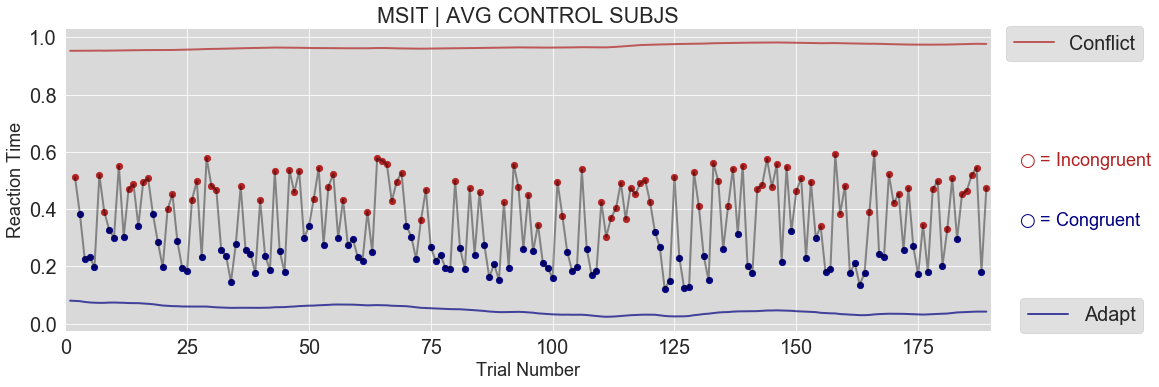

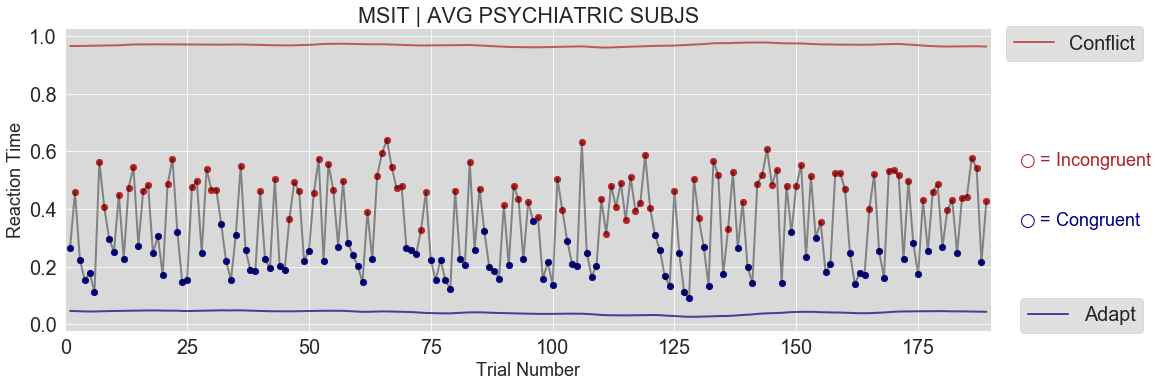

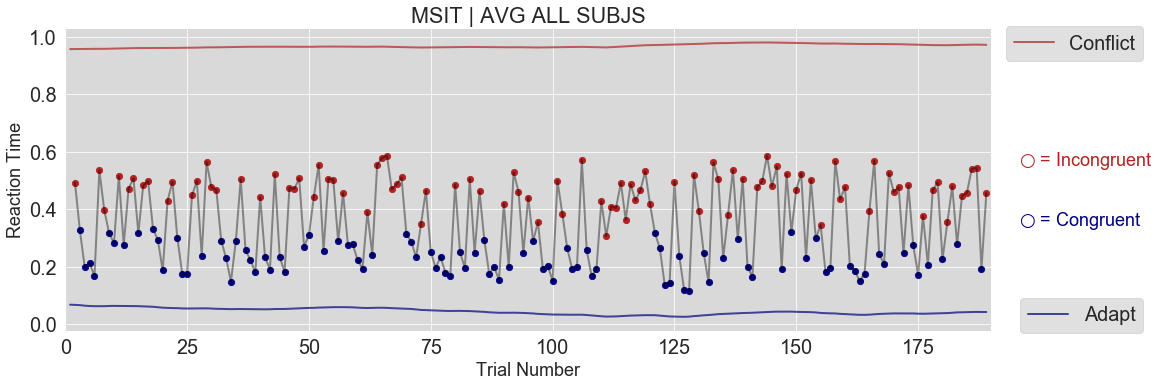

In [6]:
def ss_rt_plots(df_type,sub_or_group):
    ##---------------------------------##
    ## Plot SS and Behvaior
    ##---------------------------------##  
    plt.style.use('fivethirtyeight')
    sns.set_style("darkgrid",{"axes.facecolor":".85"})
    sns.set_context('paper', font_scale=2.25)
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ## Plot reaction time and trial timeseries
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    fig = plt.figure(figsize=(20,7))
    ax = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
    ss_title="MSIT | %s" % sub_or_group
    colors = np.where(df_type["cond"], 'firebrick', 'navy')
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ## Use when plotting indivs or groups (not averages)
#     markers = np.where(df_type["acc"],'o','x').squeeze()
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ax.plot(df_type["trial"], df_type["rt"], color='k', linewidth=2, alpha=0.4)
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    for x,y,c in zip(df_type['trial'], df_type["rt"], colors): 
        ax.scatter(x,y,s=40,color=c)
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ## Use when plotting indivs or groups (not averages)
#     for x,y,c,m in zip(df_type['trial'], df_type["rt"], colors, markers): 
#         ax.scatter(x,y,s=40,marker=m,color=c)
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    for color, label in zip(['navy', 'firebrick'], ['C','I']): 
        ax.scatter([],[], s=60, color=color, label=label)
    # Configure matplotlib.patch.Patch properties
    props = dict(facecolor='white',alpha=0.5)
    ax.text(1.03, 0.6, r'$\bigcirc$ = Incongruent', transform=ax.transAxes, fontsize=18,\
        verticalalignment='top', bbox=props, color='firebrick')
    ax.text(1.03, 0.4, r'$\bigcirc$ = Congruent', transform=ax.transAxes, fontsize=18,\
        verticalalignment='top', bbox=props, color='navy')
    ax.set_xlim(0,190)
    ax.set_xlabel('Trial Number', fontsize=18)
    ax.set_ylabel('Reaction Time', fontsize=18)
    ax.set_title('%s' % ss_title,loc='center')
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ## Plot state space
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    line1,=ax.plot(df_type["trial"],df_type["conflict"],linewidth=2,alpha=0.7,color='firebrick',label='Conflict')
    line2,=ax.plot(df_type["trial"],df_type["adapt"],linewidth=2,alpha=0.7,color='navy',label='Adapt')
#     Conflict legend
    first_legend = plt.legend(handles=[line1],loc=7, bbox_to_anchor=(1.175,0.95))
    ax = plt.gca().add_artist(first_legend)
#     Adaptation legend
    plt.legend(handles=[line2],loc=7, bbox_to_anchor=(1.175, 0.05))
    sns.despine()
    plt.show() 
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# ss_rt_plots(df,'ALL SUBJS')
# ss_rt_plots(df_hcs,'CONTROL SUBJS')
# ss_rt_plots(df_pts,'PSYCHIATRIC SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
ss_rt_plots(df_hcs_avg,'AVG CONTROL SUBJS')
ss_rt_plots(df_pts_avg,'AVG PSYCHIATRIC SUBJS')
ss_rt_plots(df_avg,'AVG ALL SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     ss_rt_plots(df_sub,subj.upper())

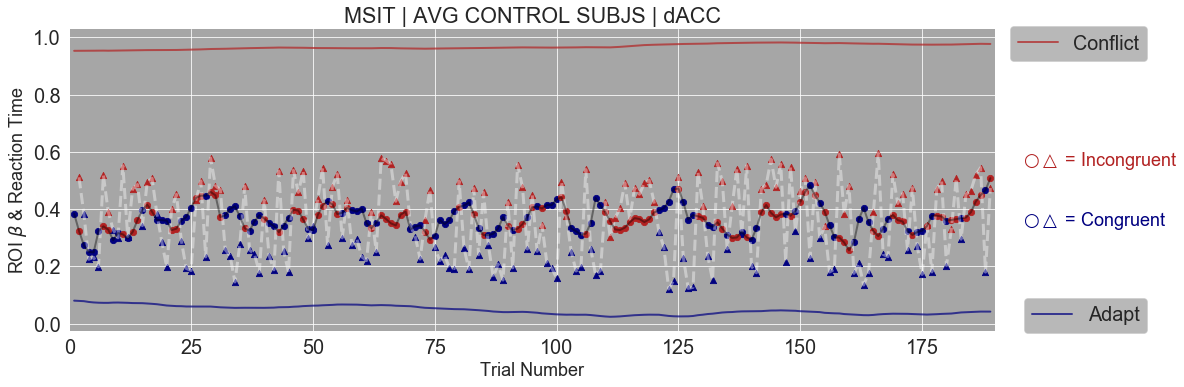

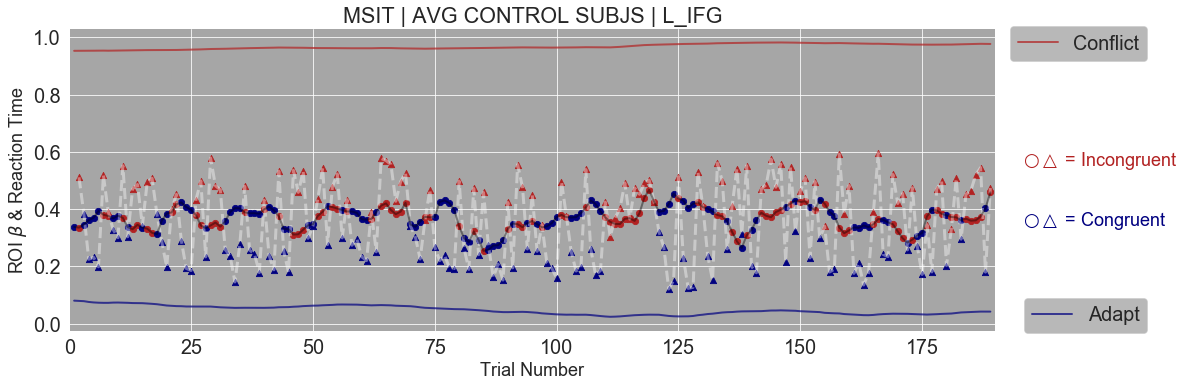

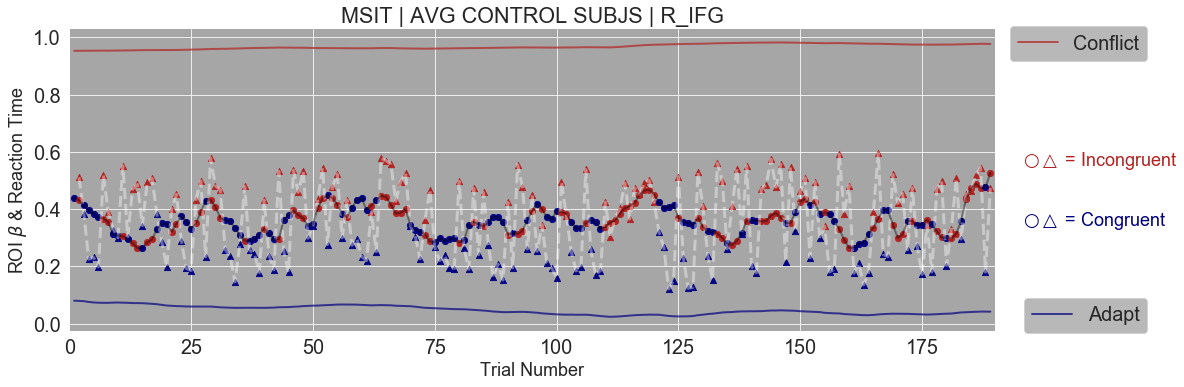

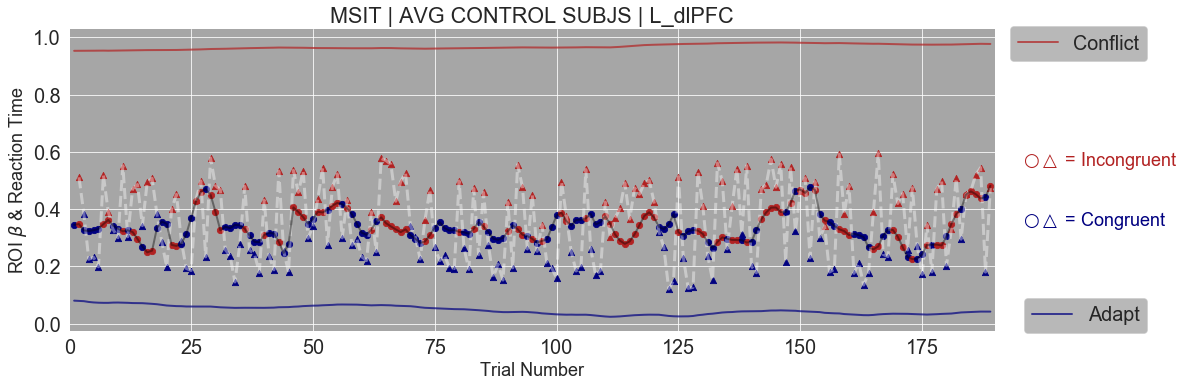

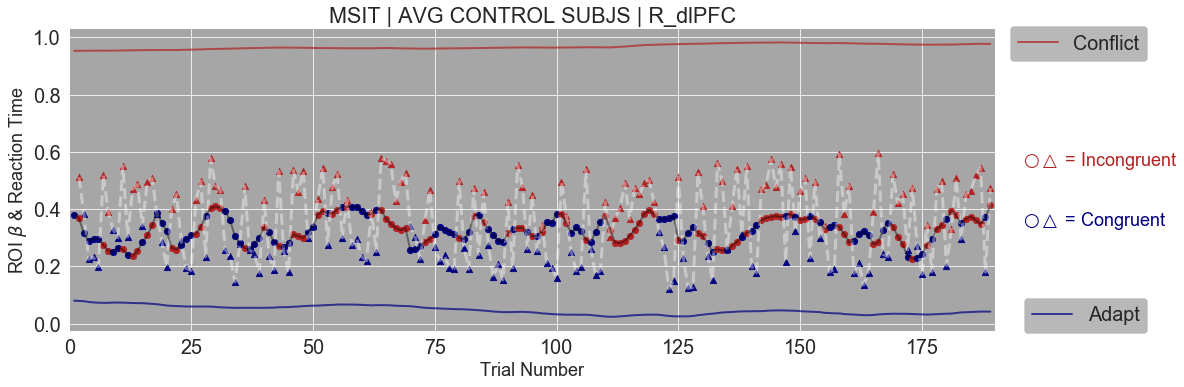

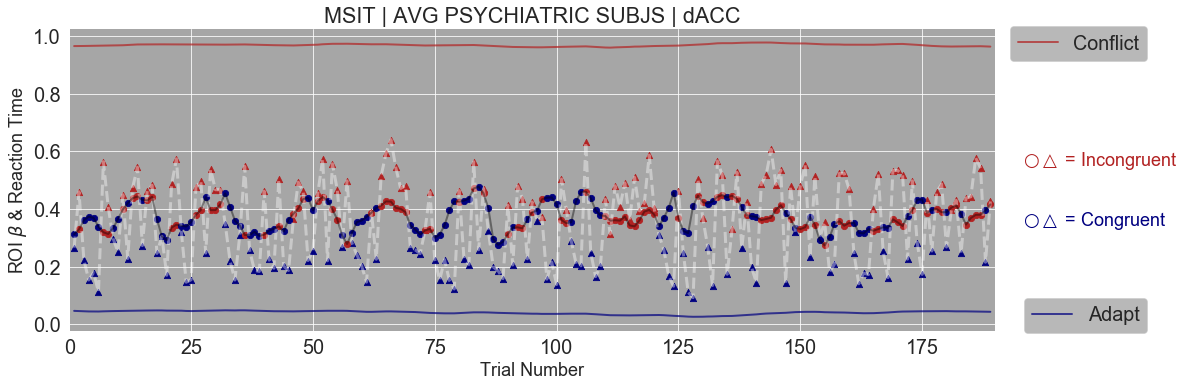

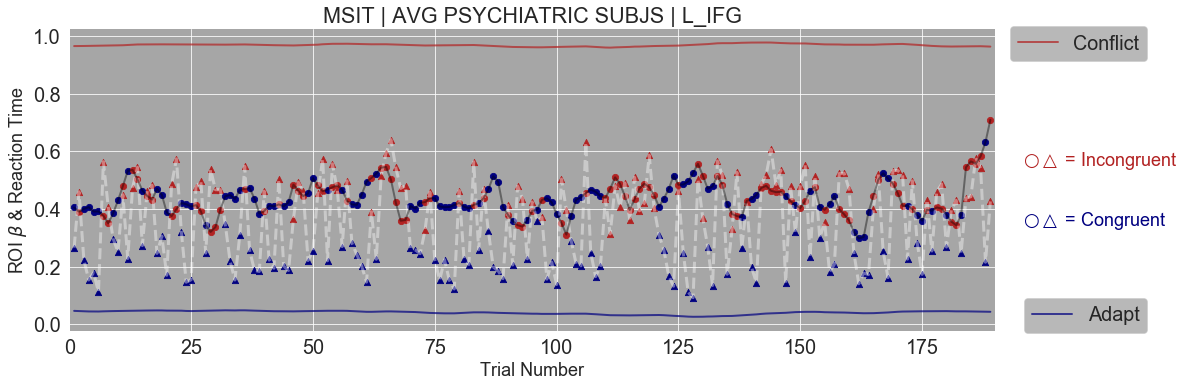

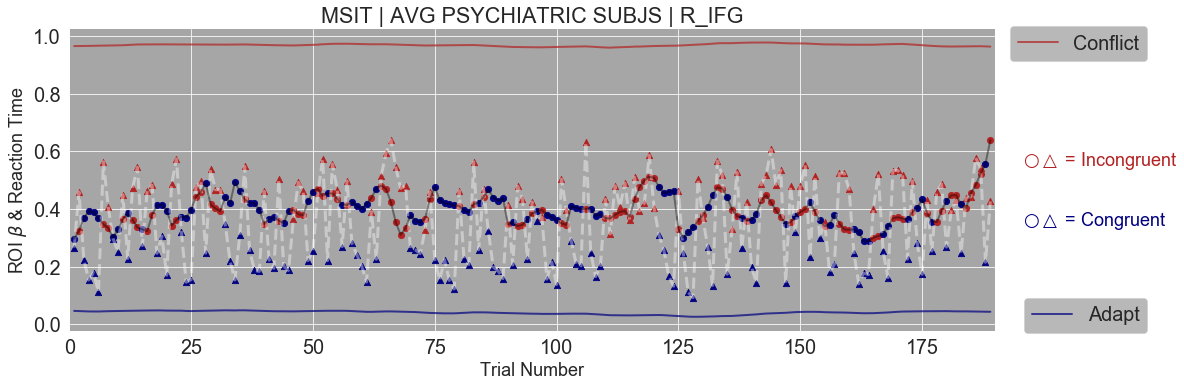

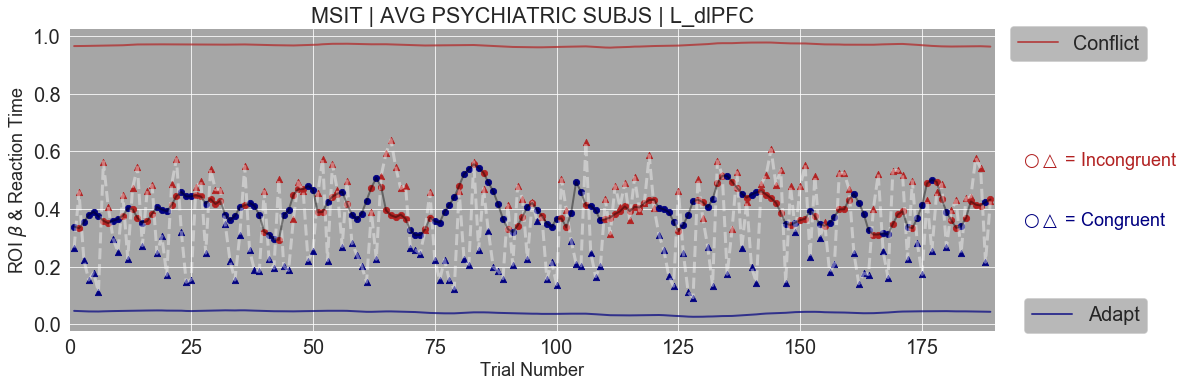

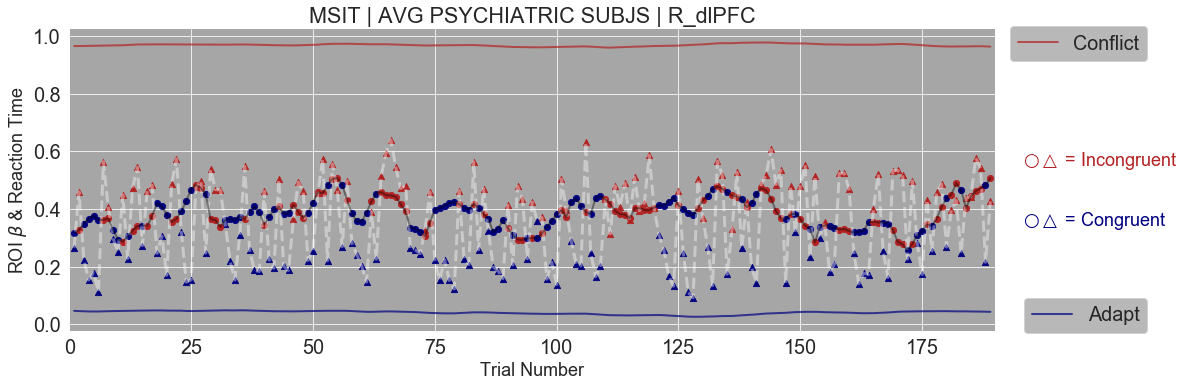

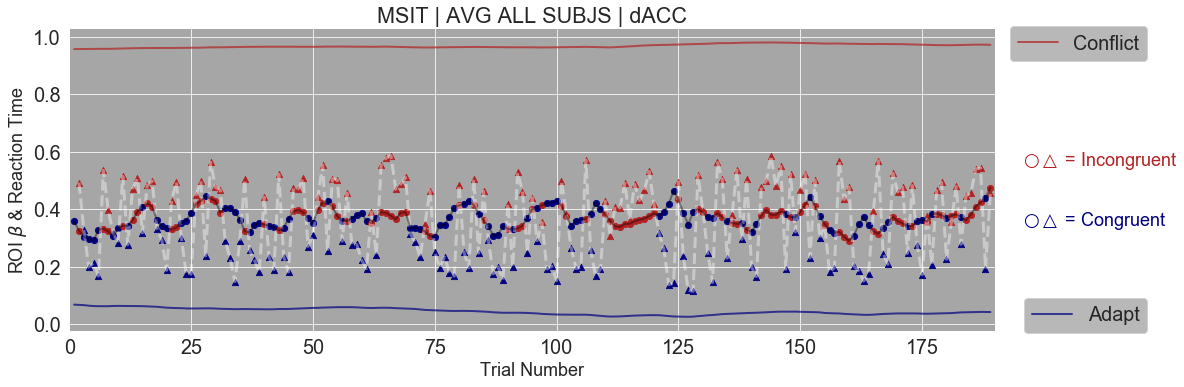

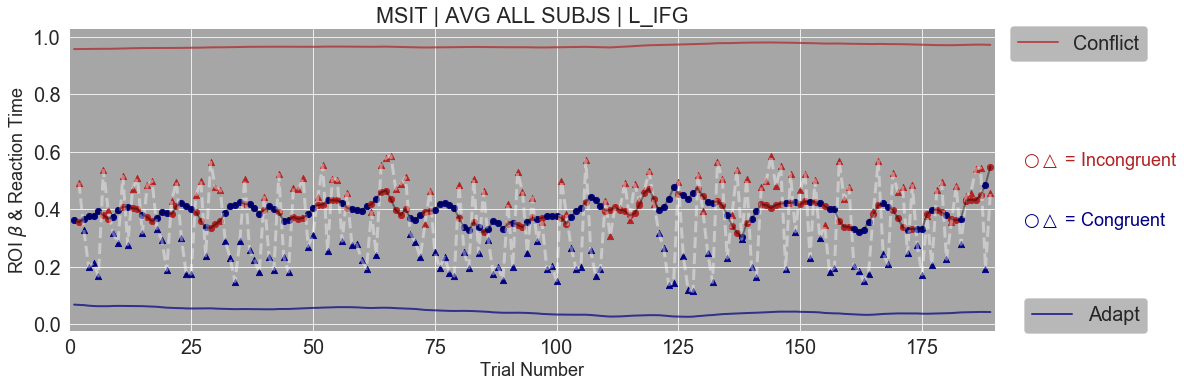

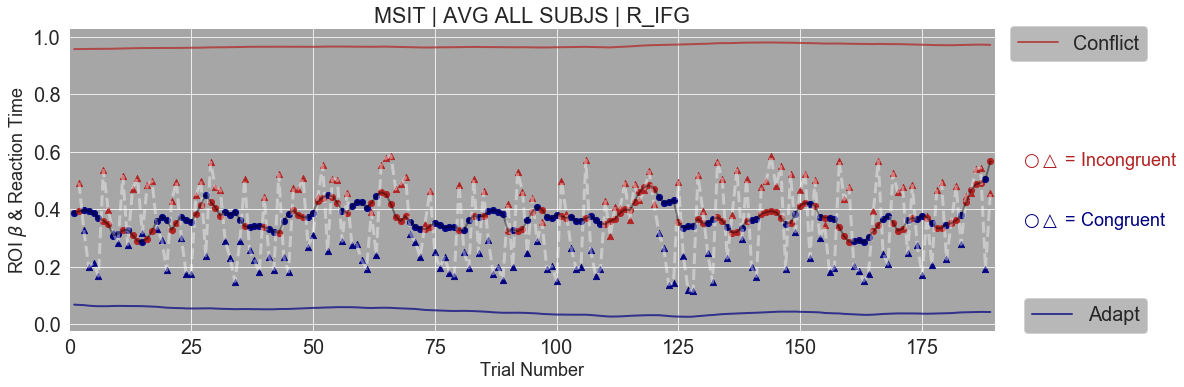

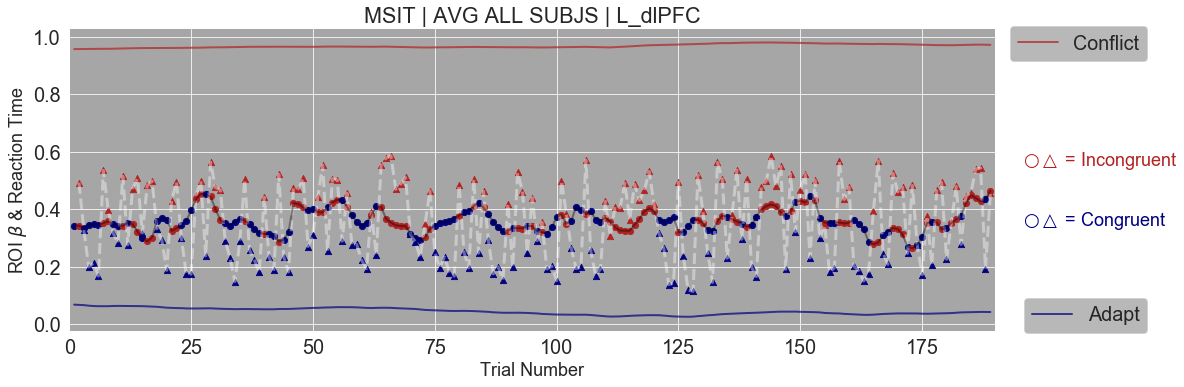

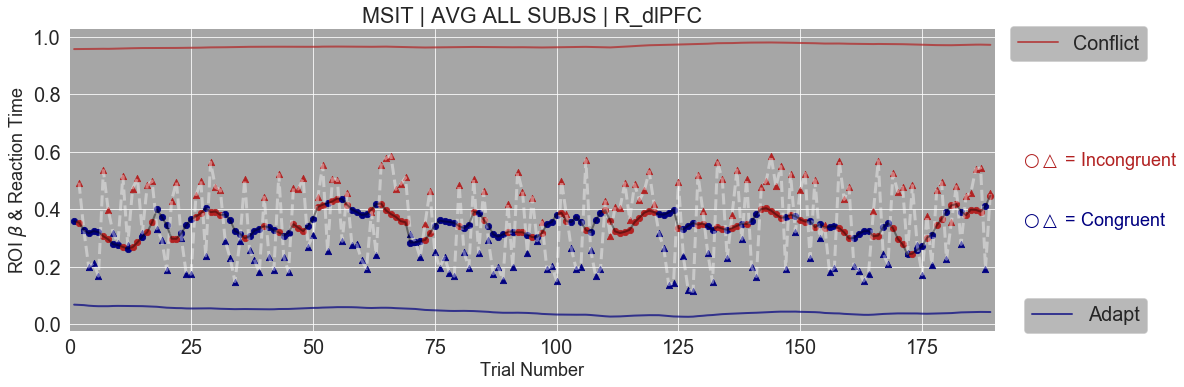

In [7]:
def ss_roi_plots(df_type,sub_or_group):
    for region in ['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']:
        ##---------------------------------##
        ## Plot SS and Behvaior
        ##---------------------------------##  
        plt.style.use('fivethirtyeight')
        sns.set_style("darkgrid",{"axes.facecolor":".65"})
        sns.set_context('paper', font_scale=2.25)
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ## Plot reaction time and trial timeseries
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        fig = plt.figure(figsize=(20,7))
        ax = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
        ss_title="%s | %s" % (sub_or_group,region)
        colors = np.where(df_type["cond"], 'firebrick', 'navy')
#         colors2 = np.where(df_type["cond"], 'k', 'y')
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ## Use when plotting indivs or groups (not averages)
#         markers = np.where(df_type["acc"],'o','x').squeeze()
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ax.plot(df_type['trial'], df_type['rt'], color='w',linewidth=3, alpha=0.4,linestyle="dashed")
        ax.plot(df_type['trial'], df_type['%s' % region], color='k', linewidth=2, alpha=0.4)
#         for x,y,c,m in zip(df_type['trial'], df_type['%s' % region], colors, markers):
#             ax.scatter(x,y,s=40,marker=m,color=c)
#         for x,y,c,m in zip(df_type['trial'], df_type['rt'], colors, markers):
#             ax.scatter(x,y,s=40,marker=m,color=c)
        for x,y,c in zip(df_type['trial'], df_type['rt'], colors):
            ax.scatter(x,y,s=40,color=c,marker="^")
        for x,y,c in zip(df_type['trial'], df_type['%s' % region], colors):
            ax.scatter(x,y,s=40,color=c,marker='o')
        for color, label in zip(['navy', 'firebrick'], ['C','I']): 
            ax.scatter([],[], s=60, color=color, label=label)
        # Configure matplotlib.patch.Patch properties
        props = dict(facecolor='white',alpha=0.5)
        ax.text(1.03, 0.6, r'$\bigcirc \bigtriangleup$ = Incongruent', transform=ax.transAxes, fontsize=18,\
            verticalalignment='top', bbox=props, color='firebrick')
        ax.text(1.03, 0.4, r'$\bigcirc \bigtriangleup$ = Congruent', transform=ax.transAxes, fontsize=18,\
            verticalalignment='top', bbox=props, color='navy')
        ##ax.text(1.03, 0.5, r'$\bullet$ = $\beta$', transform=ax.transAxes, fontsize=18,\
            ##verticalalignment='top', bbox=props, color='gold')
        ax.set_xlim(0,190)
        ax.set_xlabel('Trial Number', fontsize=18)
        ax.set_ylabel(r'ROI $\beta$ & Reaction Time', fontsize=18)
        ax.set_title('MSIT | %s' % ss_title,loc='center')
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        ## Plot state space
        ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        line1,=ax.plot(df_type["trial"],df_type["conflict"],linewidth=2,alpha=0.7,color='firebrick',label='Conflict')
        line2,=ax.plot(df_type["trial"],df_type["adapt"],linewidth=2,alpha=0.7,color='navy',label='Adapt')
        ## Conflict legend
        first_legend = plt.legend(handles=[line1],loc=7, bbox_to_anchor=(1.175,0.95))
        ax = plt.gca().add_artist(first_legend)
        ## Adaptation legend
        plt.legend(handles=[line2],loc=7, bbox_to_anchor=(1.175, 0.05))
        sns.despine()
        plt.show() 
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# ss_roi_plots(df,'ALL SUBJS')
# ss_roi_plots(df_hcs,'CONTROL SUBJS')
# ss_roi_plots(df_pts,'PSYCHIATRIC SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
ss_roi_plots(df_hcs_avg,'AVG CONTROL SUBJS')
ss_roi_plots(df_pts_avg,'AVG PSYCHIATRIC SUBJS')
ss_roi_plots(df_avg,'AVG ALL SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     ss_roi_plots(df_sub,subj.upper())

### Visualize Beta Series Method Timeseries

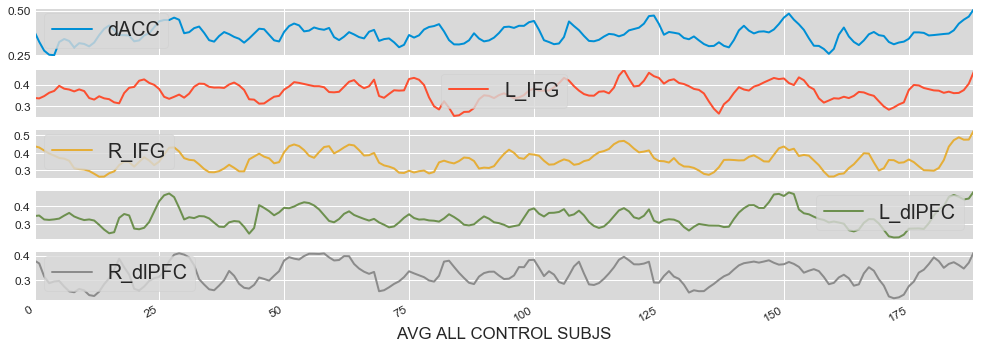

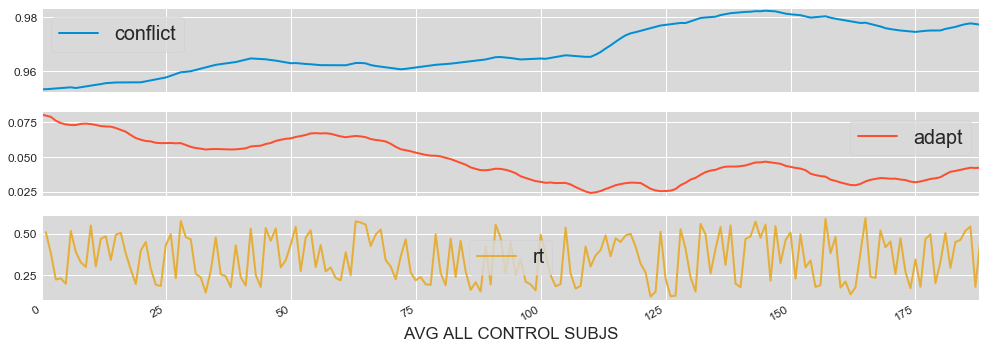

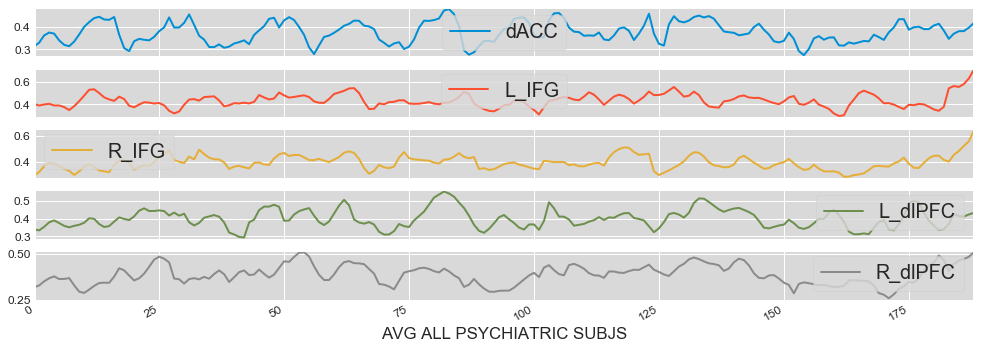

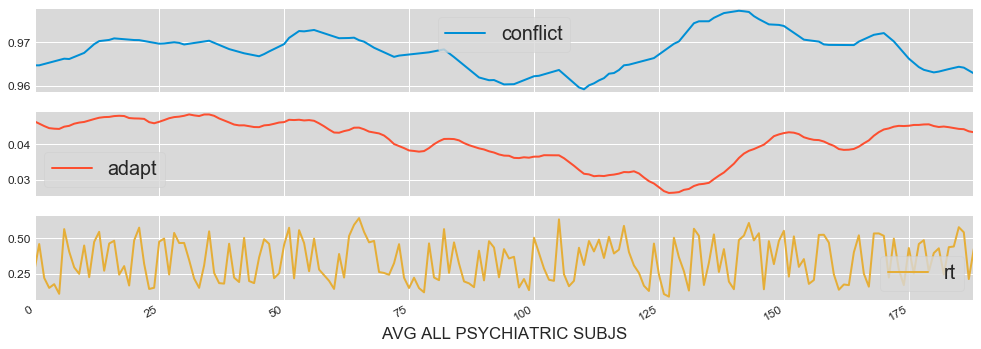

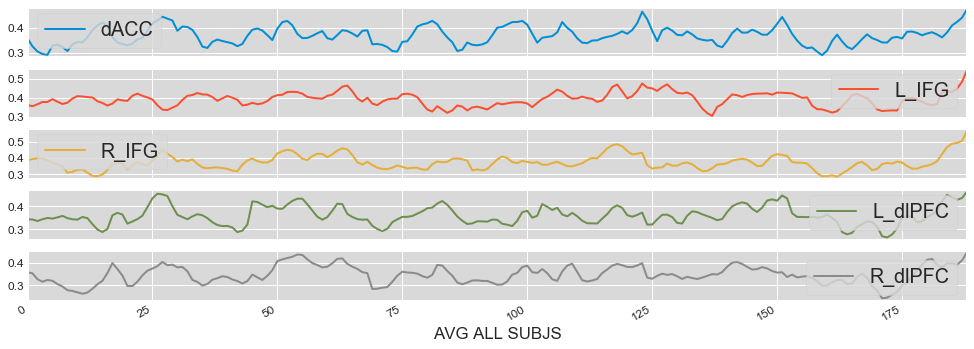

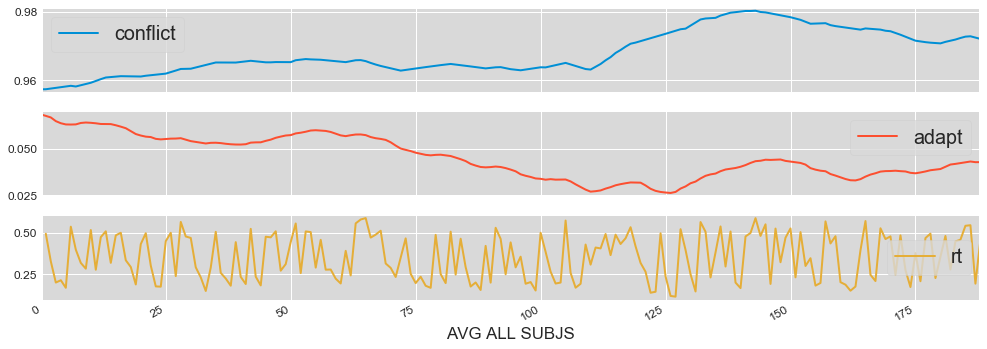

In [8]:
def timeseries_plots(df_type,sub_or_group):
    plt.style.use('fivethirtyeight')
    sns.set_style("darkgrid",{"axes.facecolor":".85"})
    ##---------------------------------##
    ##  Display fMRI time-series
    ##---------------------------------##  
    df_rois = df_type[['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']].copy()
    df_rois.plot(subplots=True,figsize=(15, 6),fontsize=12,legend='right',linewidth=2)
    plt.xlabel("%s" % sub_or_group)
    plt.show()
    
    df_vars = df_type[['conflict','adapt','rt']].copy()
    df_vars.plot(subplots=True,figsize=(15, 6),fontsize=12,legend='right',linewidth=2)
    plt.xlabel("%s" % sub_or_group)
    plt.show()
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# timeseries_plots(df,'ALL SUBJS')
# timeseries_plots(df_hcs,'CONTROL SUBJS')
# timeseries_plots(df_pts,'PSYCHIATRIC SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot AVERAGED Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
timeseries_plots(df_hcs_avg,'AVG ALL CONTROL SUBJS')
timeseries_plots(df_pts_avg,'AVG ALL PSYCHIATRIC SUBJS')
timeseries_plots(df_avg,'AVG ALL SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     timeseries_plots(df_sub,subj.upper())

### Distribution of ITIs

In [9]:
# import glob
# import pandas as pd
# import seaborn as sns
# import os

# ITIs=[]
# s='hc001'
# bcsv=glob.glob(os.path.join(raw_behav_dir,'%s*' % s))
# for i in bcsv:
#     b=pd.read_csv(i)
#     for d,st in zip(b['Duration'],b['Stimuli']):
#         if st=='+':
#             ITIs.append(d)
#         else:
#             ITIs.append('0')
# sns.set()
# plt.subplots(figsize=(5,10))
# c=pd.DataFrame()
# c['ITIs']=ITIs
# ax=sns.countplot(c['ITIs'],linewidth=5,facecolor=(0, 0, 0, 0),\
#               edgecolor=sns.color_palette("Set2", 3),\
#               order = c['ITIs'].value_counts().index)
# for p in ax.patches:
#         ax.annotate('   {:}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+2))
# plt.show()